In [1]:
# MCMC evaluation of M1 coupling constant distributions
# Fox 2021
#

version = 2.0

# v1 : gaussian prior
# v2 : uniform prior

#import pdb

import numpy as np
import os, sys
from glob import glob
from tqdm import tqdm
from time import time
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'serif',
        'serif'  : ['Palatino'],
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
import pandas as pd
import pickle as pkl
import emcee
from multiprocessing import Pool
from scipy.optimize import minimize, minimize_scalar

# IGNORE DIVIDE BY ZERO WARNINGS
np.seterr(divide='ignore')

def optimal_n_bins(y,max_bins=100):
    from scipy.stats import iqr
    n_bins = int((max(y) - min(y))/(2*iqr(y)*len(y)**(-1/3)))
    return min(n_bins,max_bins)

#def Bweisskopf(l,A):
#    # Weisskopf (single-particle) estimate in e^2 fm^2l
#    return (1/(4*np.pi)) * (3/(3+l))**2 * (1.2*A**(1/3))**(2*l)

def B_M1_Wu(B):
    return B / 1.79

In [2]:
print('Loading data...')
fn_data_for_model = 'm1_data_for_model_071121.pkl'
with open(fn_data_for_model,'rb') as fh:
    [nuc_dict_list, Mth_sp_usdb_list, Mth_sn_usdb_list, Mth_lp_usdb_list, Mth_ln_usdb_list, Mth_sp_vec_list, Mth_sn_vec_list, Mth_lp_vec_list, Mth_ln_vec_list, title_string_list, Bexp_Wu_list, Bexp_unc_Wu_list] = pkl.load(fh)

Loading data...


In [3]:
A_vec = np.array([nuc_dict['A'] for nuc_dict in nuc_dict_list])
Bexp_Wu_vec = np.array(Bexp_Wu_list)
Bexp_unc_Wu_vec = np.array(Bexp_unc_Wu_list) 

Mth_sp_usdb_vec = np.array(Mth_sp_usdb_list)
Mth_sn_usdb_vec = np.array(Mth_sn_usdb_list)
Mth_lp_usdb_vec = np.array(Mth_lp_usdb_list)
Mth_ln_usdb_vec = np.array(Mth_ln_usdb_list)
Mth_sp_array = np.array(Mth_sp_vec_list)
Mth_sn_array = np.array(Mth_sn_vec_list)
Mth_lp_array = np.array(Mth_lp_vec_list)
Mth_ln_array = np.array(Mth_ln_vec_list)
n_transitions, n_samples = Mth_sp_array.shape
g_sp_free = 5.5857
g_lp_free = 1.
g_sn_free = -3.8263
g_ln_free = 0.
g_vec_free = (g_sp_free, g_sn_free, g_lp_free, g_ln_free)

In [4]:
def Bth_model(theta,Mth_sp,Mth_sn,Mth_lp,Mth_ln):
    g_sp,g_sn,g_lp,g_ln = theta
    Bth_vec = (g_sp * Mth_sp + g_sn * Mth_sn + g_lp * Mth_lp + g_ln * Mth_ln)**2
    return Bth_vec

def chi_squared(theta,sigmaB_apriori):
    sqr_errors = (Bexp_Wu_vec - B_M1_Wu(Bth_model(theta, Mth_sp_usdb_vec, Mth_sn_usdb_vec, Mth_lp_usdb_vec, Mth_ln_usdb_vec)) )**2
    B_unc_sqr_vec = np.array( [(sigmaB_apriori**2 + sigmaB**2) for sigmaB in Bexp_unc_Wu_vec])
    R_sqr =  sqr_errors / B_unc_sqr_vec
    return  np.sum(R_sqr)

# def chi2(g_vec,B_th_unc):
#     # in W.u.
#     R2 = (B_exp - B_M1_Wu(B_th(g_vec)))**2 / (B_exp_unc**2 + B_th_unc**2)
#     chi2 = np.sum(R2)
#     return chi2

def objective(sigmaB_apriori):
    theta_0 = (g_sp_free, g_sn_free, g_lp_free, g_ln_free)
    X2 = chi_squared(theta_0,sigmaB_apriori)
    dof = n_transitions - 4
    return (X2/dof - 1)**2

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


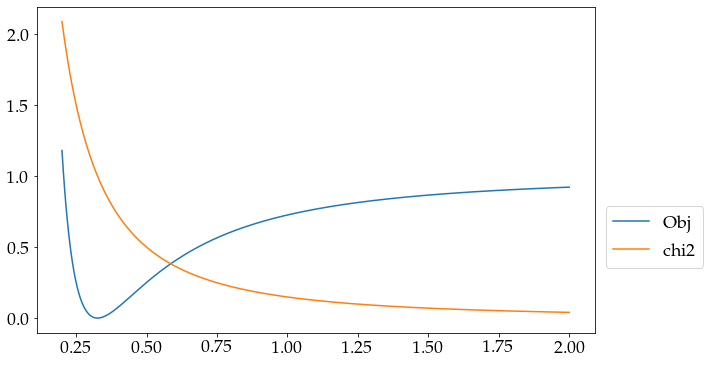

In [5]:
domain = np.linspace(0.2,2,400)
y = [objective(x) for x in domain]
y2 = [chi_squared(g_vec_free,x)/(n_transitions-4) for x in domain]

plt.figure(figsize=(10,6))
plt.plot(domain,y,label='Obj')
plt.plot(domain,y2,label='chi2')
plt.legend(loc = (1.02,0.2))
plt.show()

In [6]:
print('Finding a priori B-value uncertainty...')
opt_result = minimize_scalar(objective)
sigmaB_apriori = opt_result.x
print(f'A priori B(M1) uncertainty = {sigmaB_apriori}')

B_unc_sqr_vec = np.array( [sigmaB_apriori**2 + sigmaB**2 for sigmaB in Bexp_unc_Wu_vec] )
def likelihood(theta, sample):
    sqr_errors = (Bexp_Wu_vec - B_M1_Wu(Bth_model(theta, Mth_sp_array[:,sample], Mth_sn_array[:,sample], Mth_lp_array[:,sample], Mth_ln_array[:,sample] ) ) )**2
    R_sqr_vec =  sqr_errors / B_unc_sqr_vec
    chi_sq = np.sum(R_sqr_vec)
    return  np.exp(- 0.5 * chi_sq ) 

Finding a priori B-value uncertainty...
A priori B(M1) uncertainty = 0.32595078343047057


In [7]:
g_sp_mean = g_sp_free
g_sn_mean = g_sn_free
g_lp_mean = g_lp_free
g_ln_mean = g_ln_free
g_sp_std = 5
g_sn_std = 5
g_lp_std = 5
g_ln_std = 5
low_bound = -20
top_bound = 20

g_means = [g_sp_mean , g_sn_mean, g_lp_mean , g_ln_mean ]
g_stds = [g_sp_std  ,g_sn_std , g_lp_std  ,g_ln_std]

def normal_pdf(x,m,s):
    norm = (s * np.sqrt(2*np.pi))**-1
    return norm * np.exp( - 0.5 * (x-m)**2 / s**2)
    
def prior_normal(theta):
    p_g_sp = normal_pdf(theta[0],g_sp_mean,g_sp_std)
    p_g_sn = normal_pdf(theta[1],g_sn_mean,g_sn_std)
    p_g_lp = normal_pdf(theta[2],g_lp_mean,g_lp_std)
    p_g_ln = normal_pdf(theta[3],g_ln_mean,g_ln_std)
    return p_g_sp * p_g_sn * p_g_lp * p_g_ln
    
def prior_flat(theta):
    if all([(t>low_bound) and (t<top_bound) for t in theta]): 
        return 1.0
    else:
        return 0.0

def posterior(theta):
#     x = prior_normal(theta) * prior_flat(theta) * np.sum(np.array( [likelihood(theta,k) for k in range(n_samples)] ))
    x = prior_flat(theta) * np.sum(np.array( [likelihood(theta,k) for k in range(n_samples)] ))
    return x

def log_posterior(theta):
    return np.log(posterior(theta))

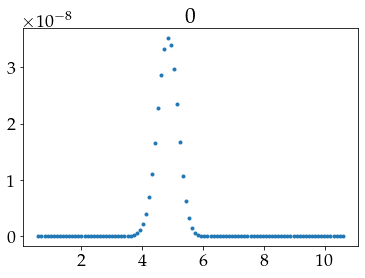

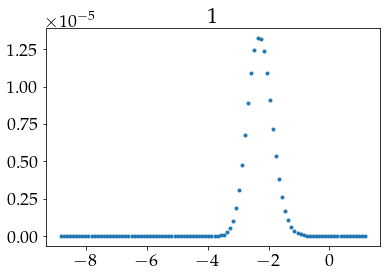

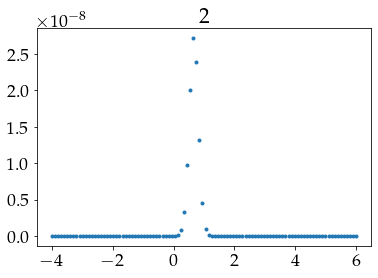

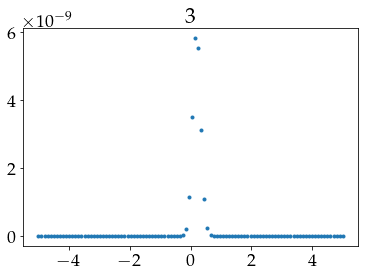

In [8]:
for r in (0,1,2,3):
#     print(g_means)
#     print(g_stds)
    domain = np.linspace(g_means[r] - g_stds[r],g_means[r] + g_stds[r], 100)
    y=[]
    for g in domain:
        t = np.copy(g_means)
        t[r] = g
        y.append(posterior(t))
    plt.plot(domain,y,'.')
    plt.title(str(r))
    plt.show()

In [1]:
# _ = input('Continue?')

n_walkers = 32
n_steps = 1000
n_params = 4
use_pool = True

def starting_point():
    g_sp = np.random.uniform(low_bound,top_bound)
    g_sn =  np.random.uniform(low_bound,top_bound)
    g_lp =  np.random.uniform(low_bound,top_bound)
    g_ln =  np.random.uniform(low_bound,top_bound)
    return [g_sp,g_sn,g_lp,g_ln]

q0 = [starting_point() for _ in range(n_walkers)]

#breakpoint()

print('Beginning MCMC...')
print(f'N walkers: {n_walkers}')
print(f'N steps: {n_steps}')

ckpt_filename = f'checkpoint_v{version}.h5'
backend = emcee.backends.HDFBackend(ckpt_filename)
backend.reset(n_walkers, n_params)

if use_pool:
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, pool=pool, backend=backend)
        start = time()
        sampler.run_mcmc(q0, n_steps, progress=True,);
        end = time()
        multi_time = end - start
        print("Multiprocessing took {0:.1f} seconds".format(multi_time))
else:
    sampler = emcee.EnsembleSampler(n_walkers, n_params, log_posterior)
    t1 = time()
    sampler.run_mcmc(q0, n_steps, progress=True,);
    t2 = time()
    print("Processing took {0:.1f} seconds".format(t2-t1))

#mu_trace = sampler.chain[:, :, 0].flatten()
#beta_trace = sampler.chain[:, :, 1].flatten()

with open(f'traces_v{version}.pkl','wb') as fh:
    pkl.dump(sampler.chain,fh)

NameError: name 'np' is not defined